In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline

from __future__ import division

import brightside as bs
import numpy as np
import ntcir
import ntcir.IO as IO
import os
import re
import itertools

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import collections
import pandas as pd

In [4]:
users = IO.load_annotations(ntcir.filepaths)
categories = IO.load_categories(ntcir.filepaths)

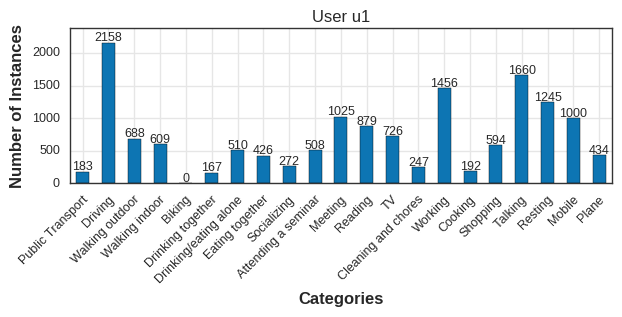

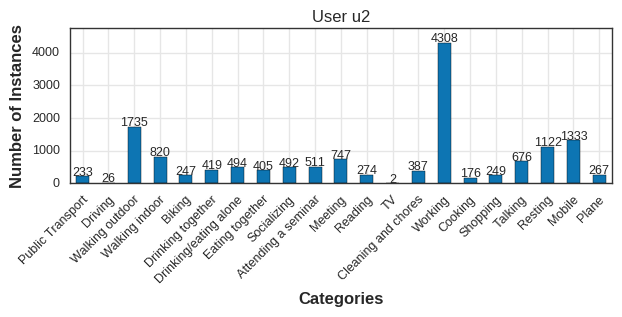

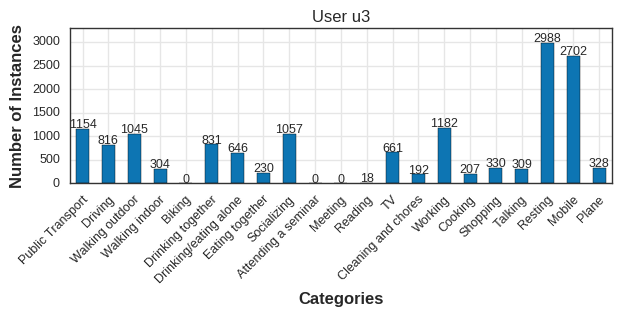

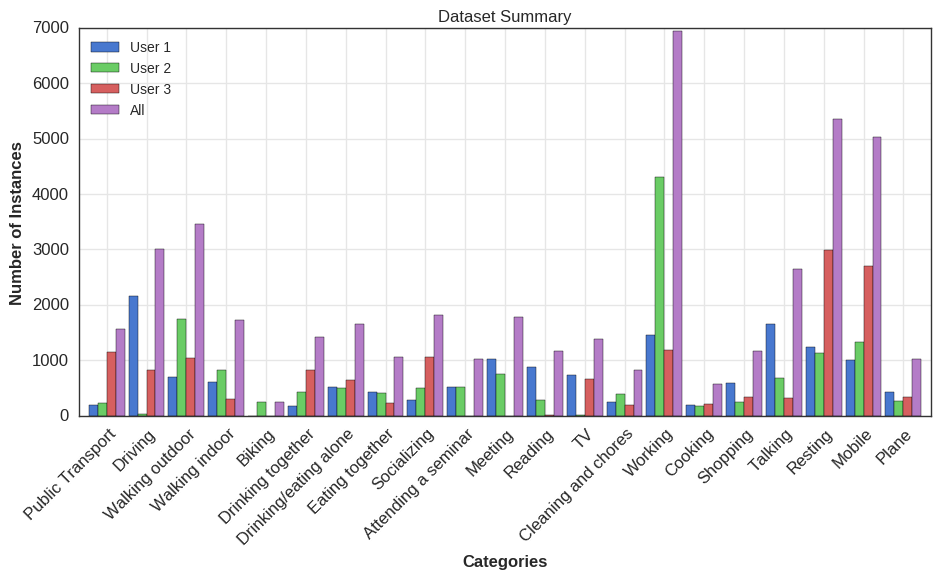

In [14]:
df = pd.DataFrame(index=categories)
histograms = np.zeros((len(categories)),dtype=np.int)
all_histograms = np.zeros((len(categories),4),dtype=np.int)
for i, user in enumerate(users):
    user_labels = list()
    for day in user.days:
        for img in day.images:
             user_labels.append(img.label)
    histogram = np.histogram(user_labels, bins=len(categories))[0]
    histograms += histogram
    
    all_histograms[:,i] = histogram
    
    user_histogram = pd.DataFrame(data=histogram, index=categories)
    fig, ax = bs.plot_datasets_summary(user_histogram,figsize=(7,2),annot_rotation=45, axis_fontsize=9,title="User " + user.id_)
    plt.show()
all_histograms[:,i+1] = histograms

histogram = pd.DataFrame(data=all_histograms,index=categories,columns=['User 1','User 2','User 3','All'])


sns.color_palette()
from matplotlib.colors import ListedColormap
my_cmap = sns.light_palette("Navy", as_cmap=True)
my_cmap = ListedColormap(sns.color_palette("muted", 4).as_hex())

fig, ax = bs.plot_datasets_summary(histogram,figsize=(11,5),legend=True,width=0.9,annotate_cols=False,annot_rotation=45,colormap=my_cmap,title='Dataset Summary')


In [15]:
colors = sns.color_palette("hls", len(categories))
np.random.shuffle(colors)
labels_colors = {i: (label, colors[i]) for i, label in enumerate(categories)}

times = list()
for time in itertools.product(xrange(24),xrange(60),xrange(0,60,30)):
    times.append(':'.join([str(t).zfill(2) for t in time]))

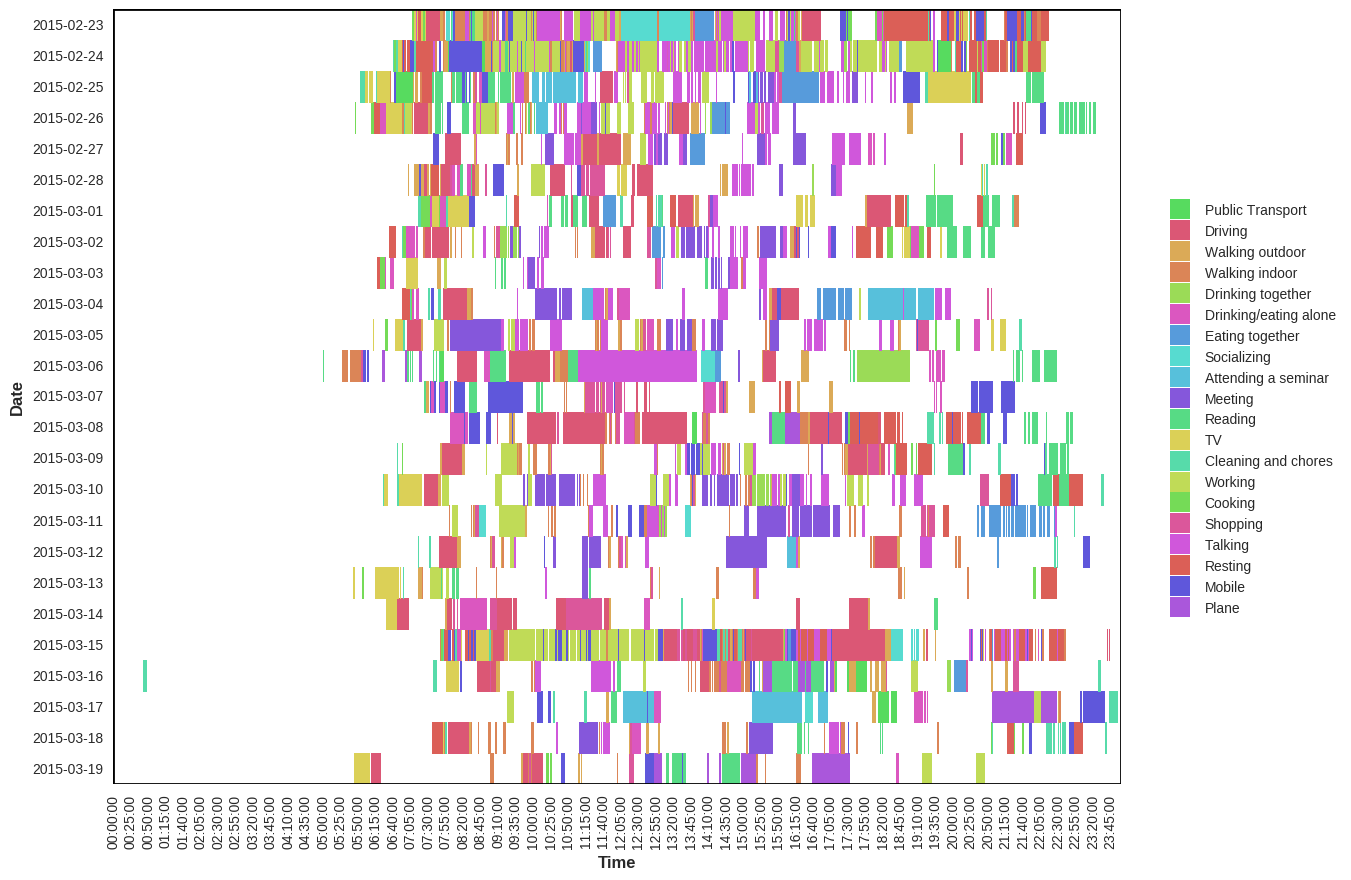

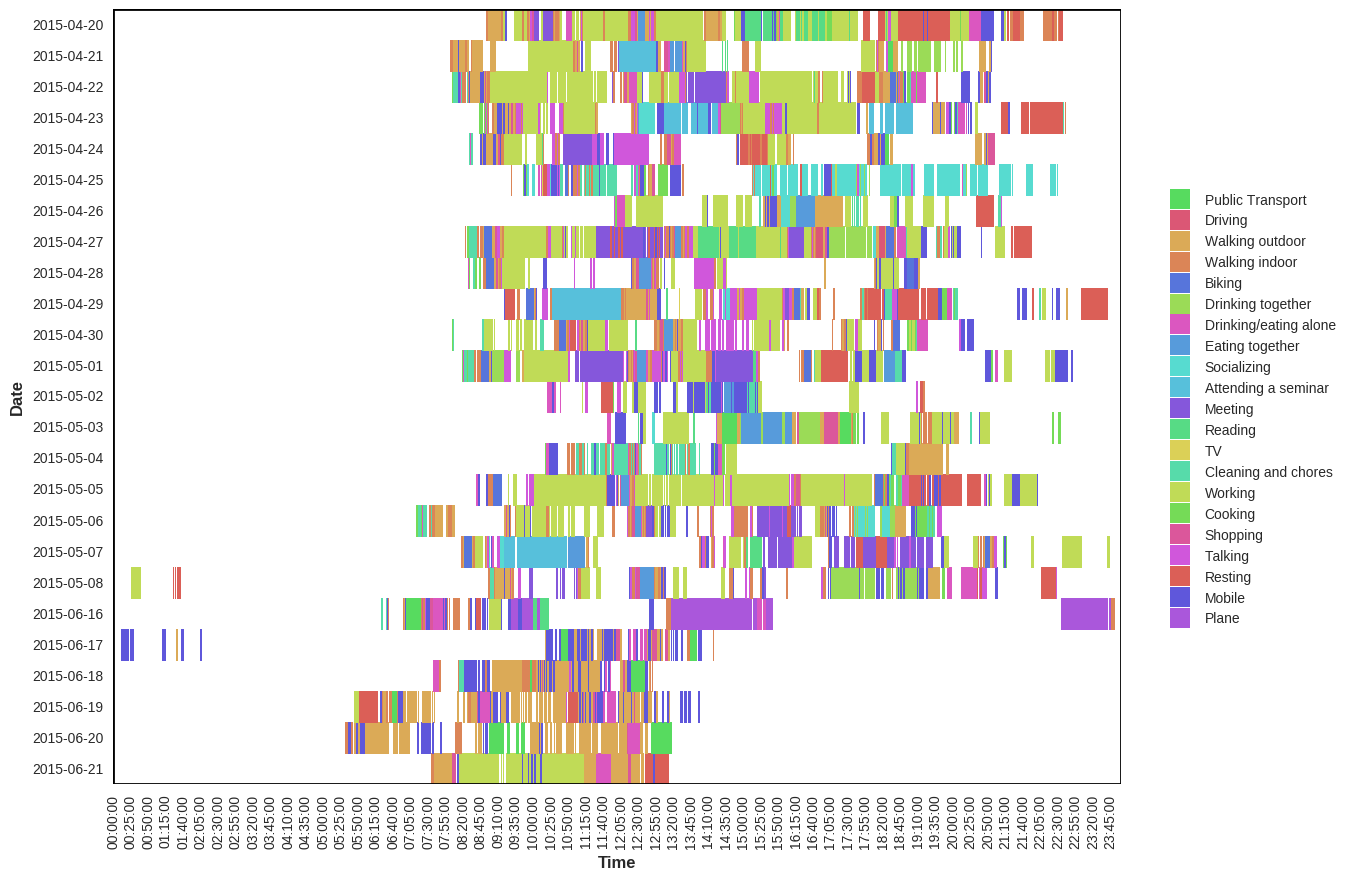

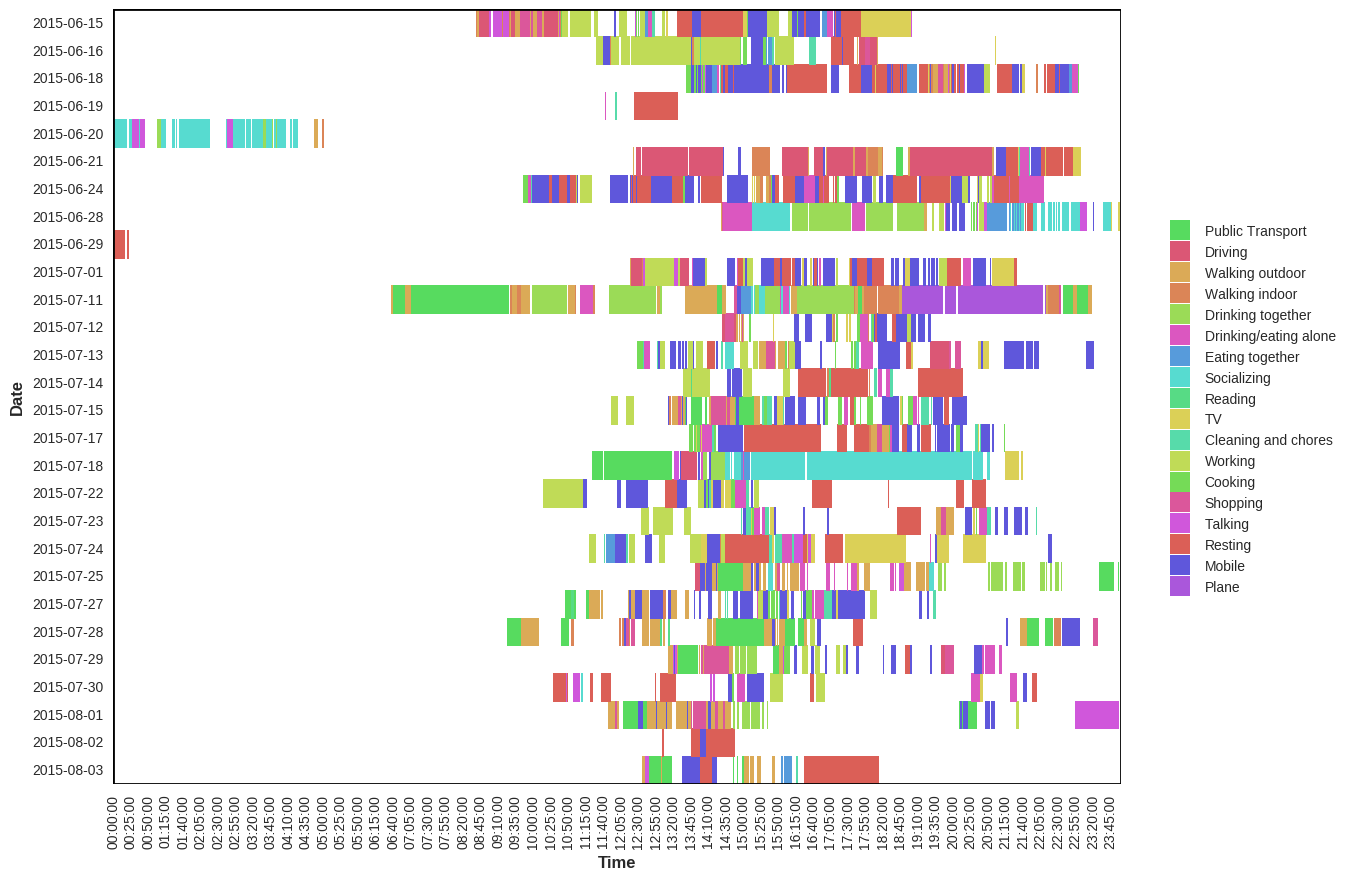

In [18]:
def time2ind(time):
    hour, minute, second =  [int(time[i:i+2]) for i in range(0, 6, 2)]
    index = 120*hour+2*minute+(1 if second > 30 else 0)
    return index

for user in users:    
    days = -np.ones((len(user.days), 2880), np.int)
    dates_labels = list()
    for i, day in enumerate(user.days):
        dates_labels.append(day.date)
        for img in day.images:
            index = time2ind(img.time)
            days[i,index] = img.label
            
    dataframe = pd.DataFrame(data=days, index=dates_labels,columns=times)        
    fig, ax = bs.show_sequences(dataframe,labels_colors,figsize=(13,10),xticklabels=50,mask_value=-1,leg_square_size=7,show_box=True,plot_xlabel='Time',plot_ylabel='Date')
    plt.show()

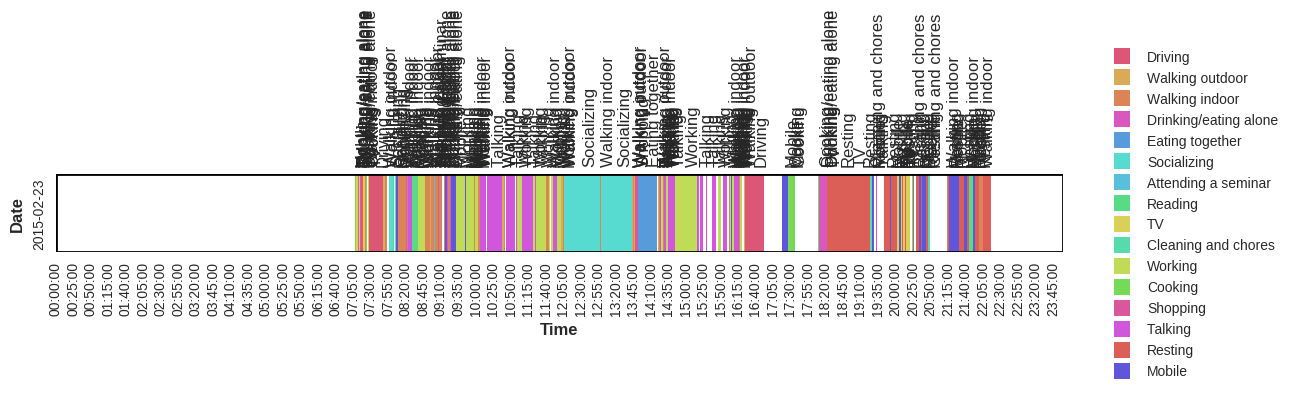

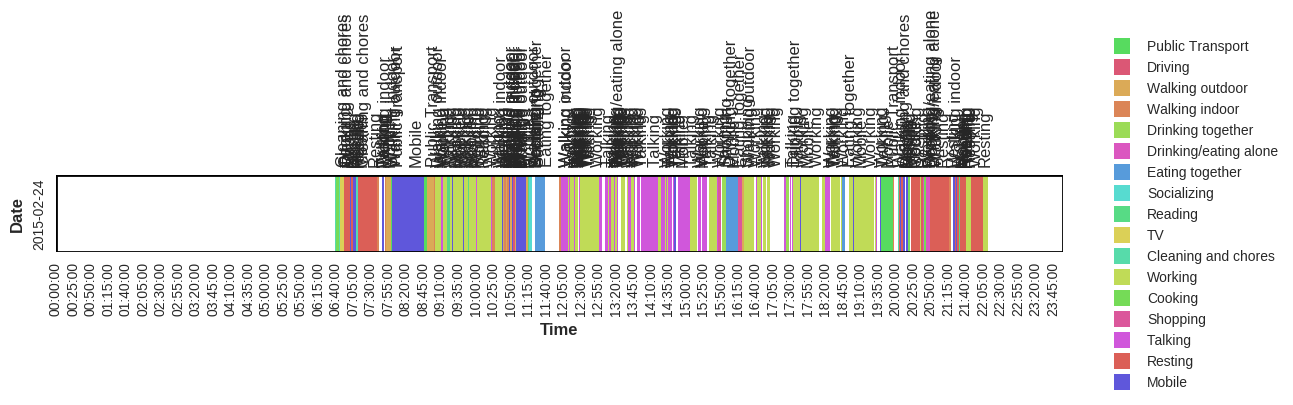

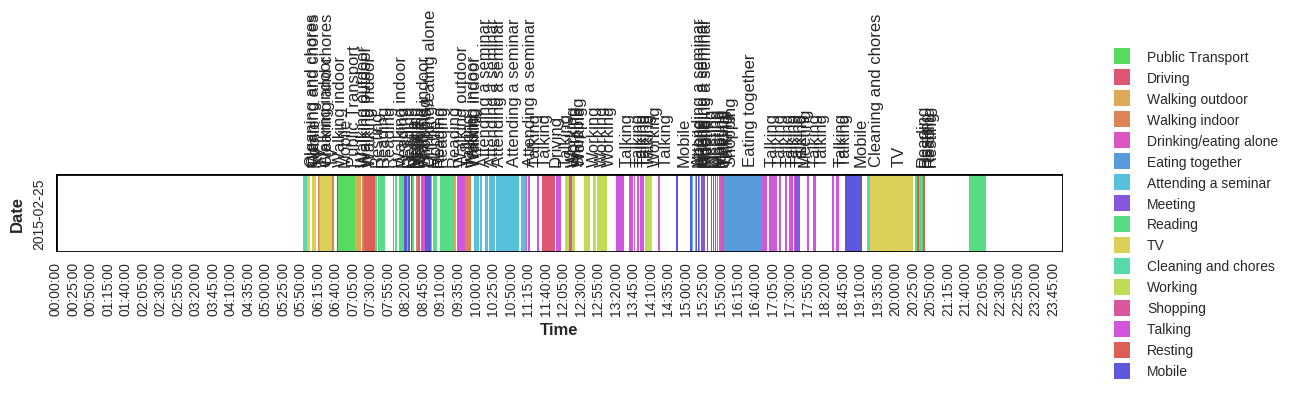

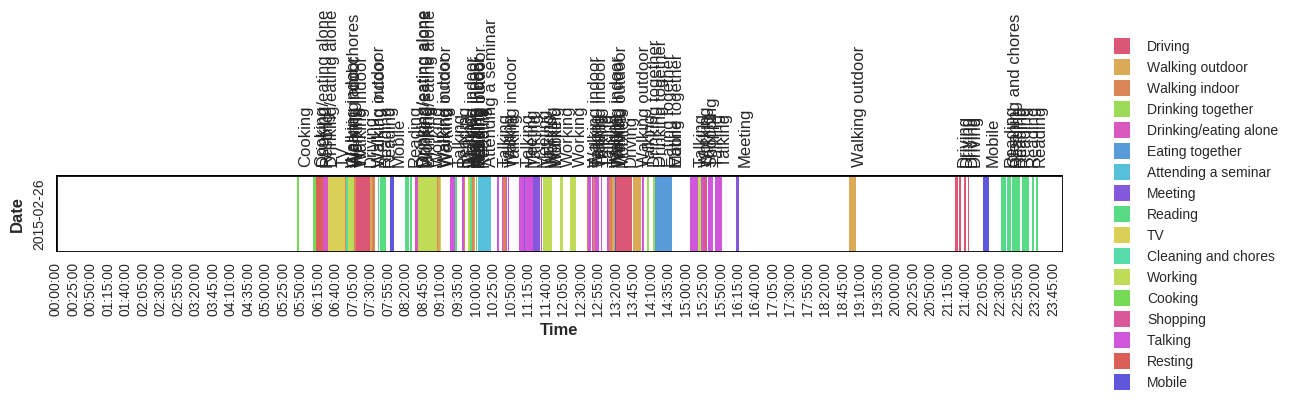

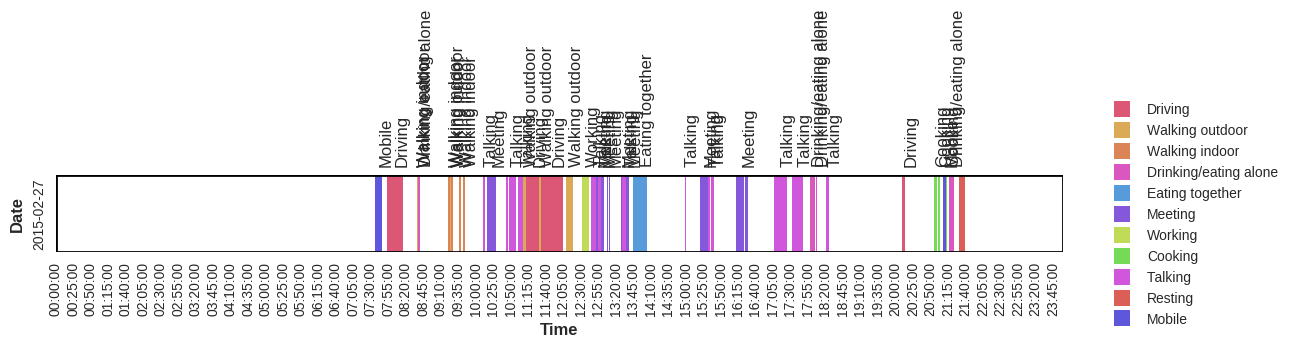

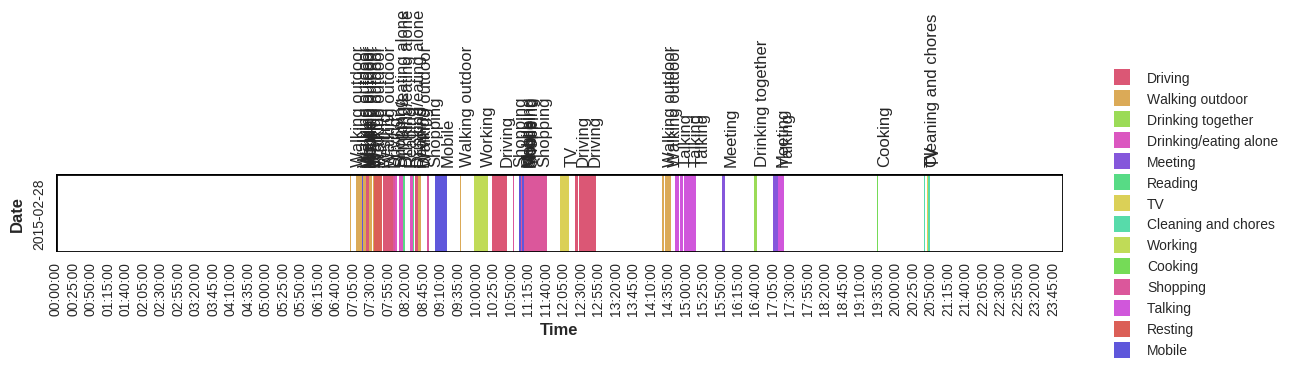

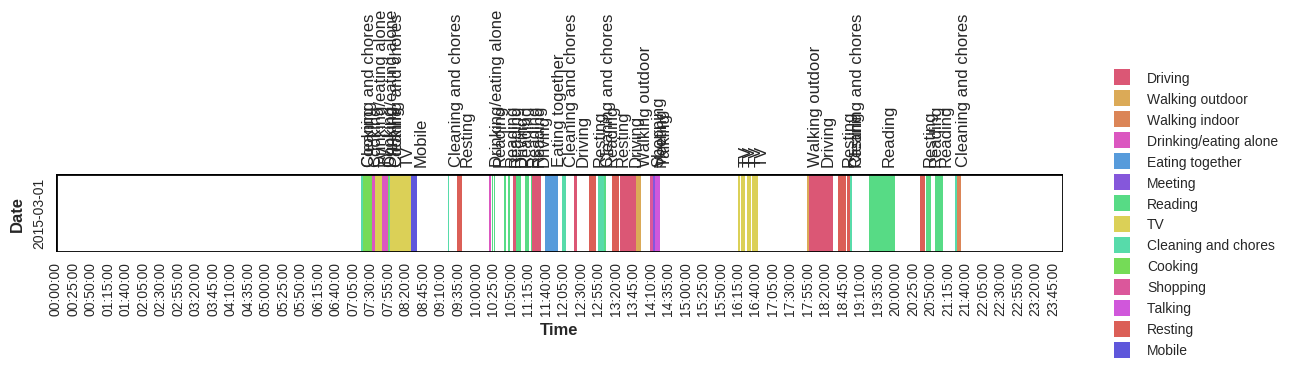

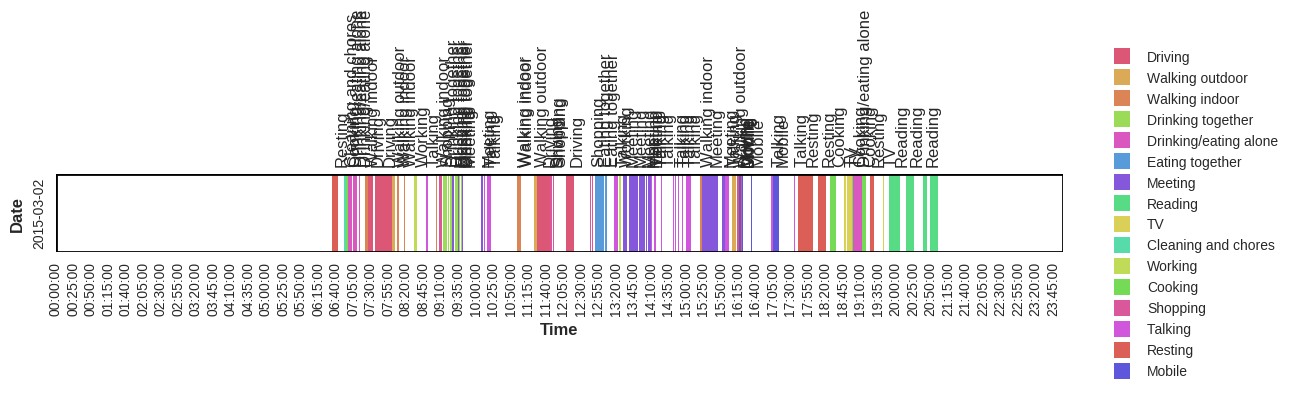

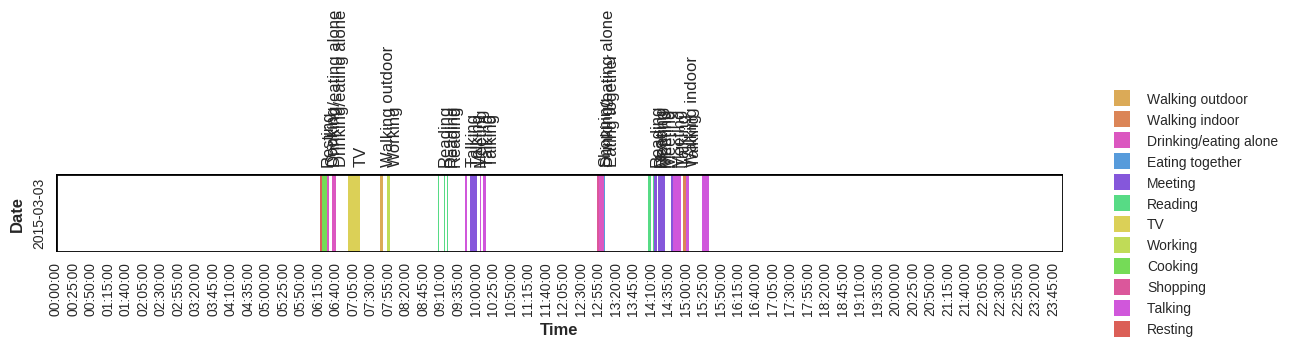

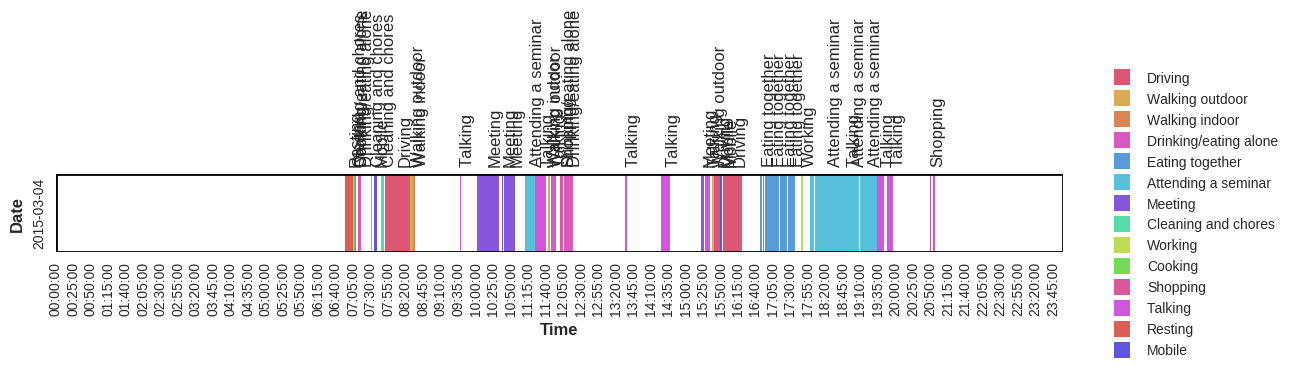

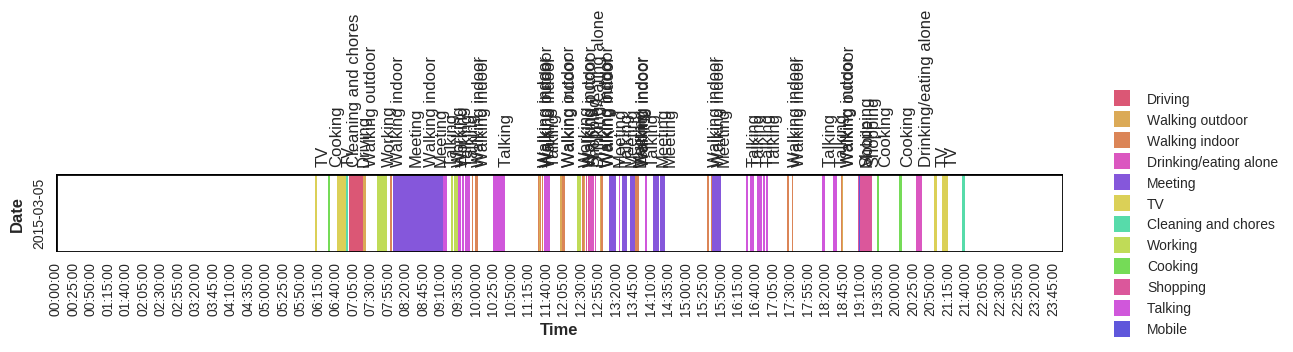

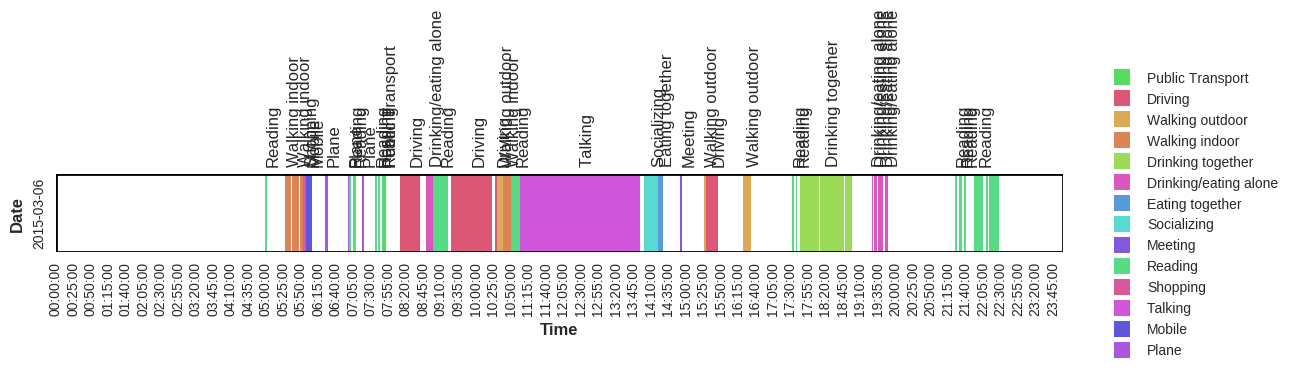

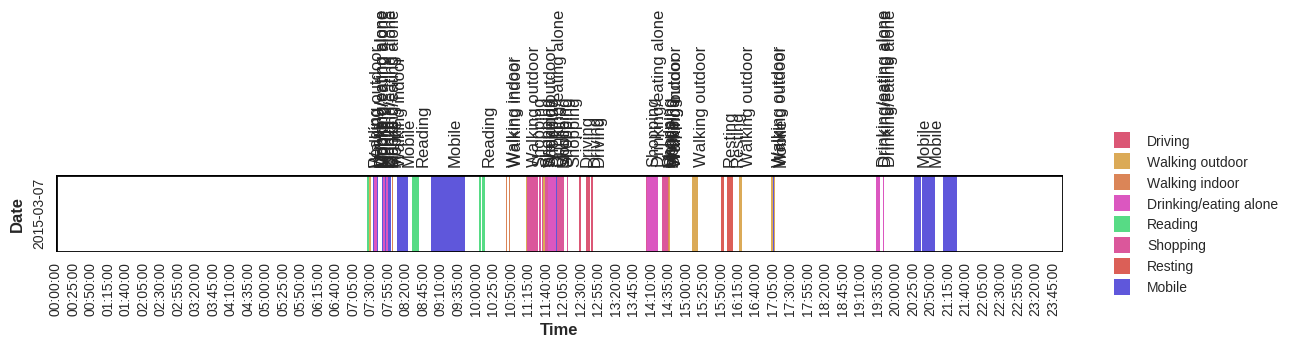

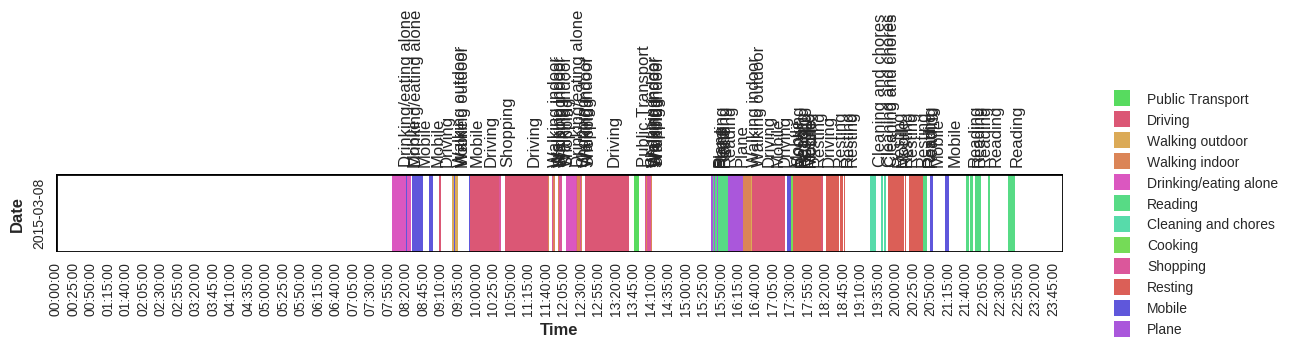

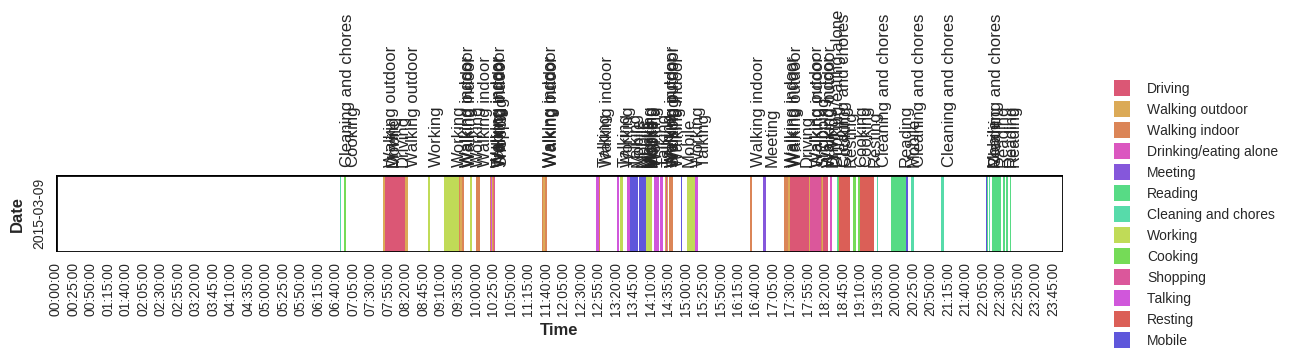

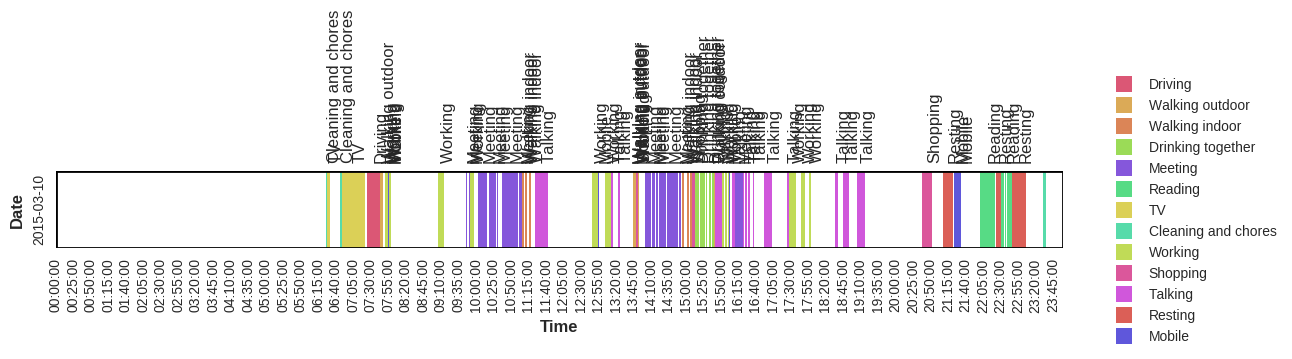

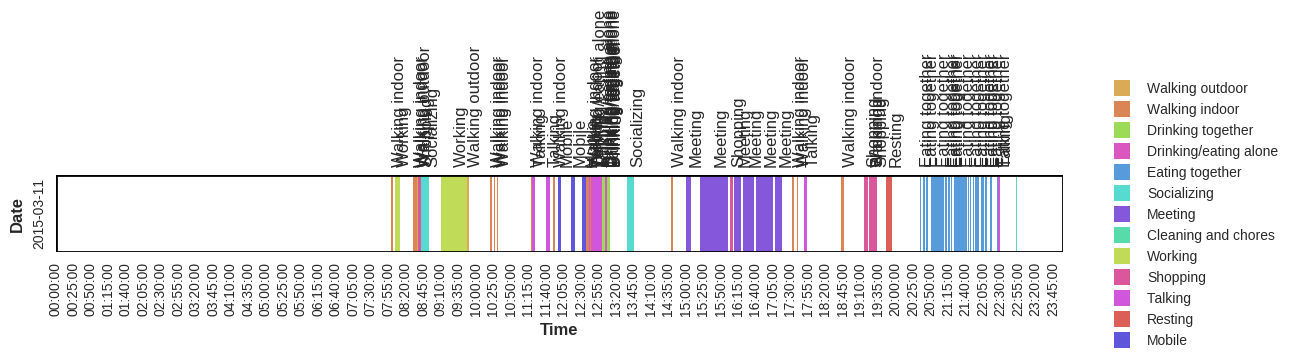

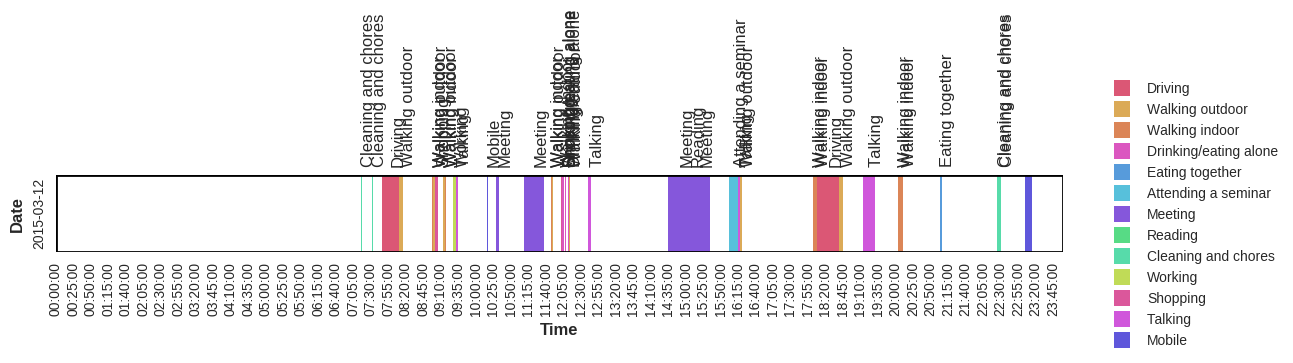

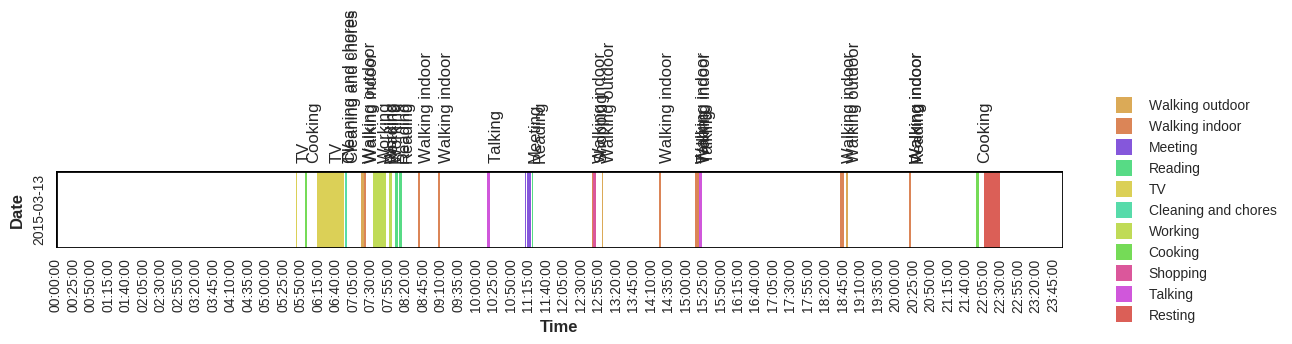

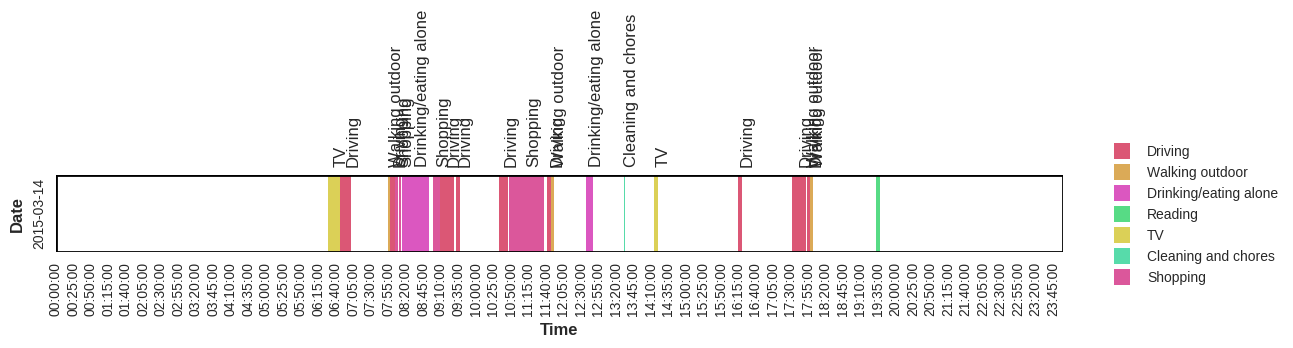

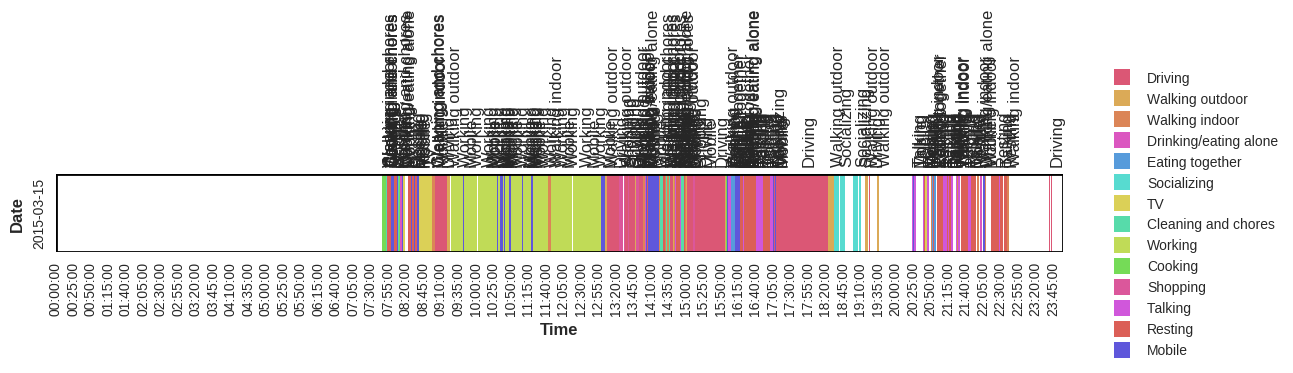

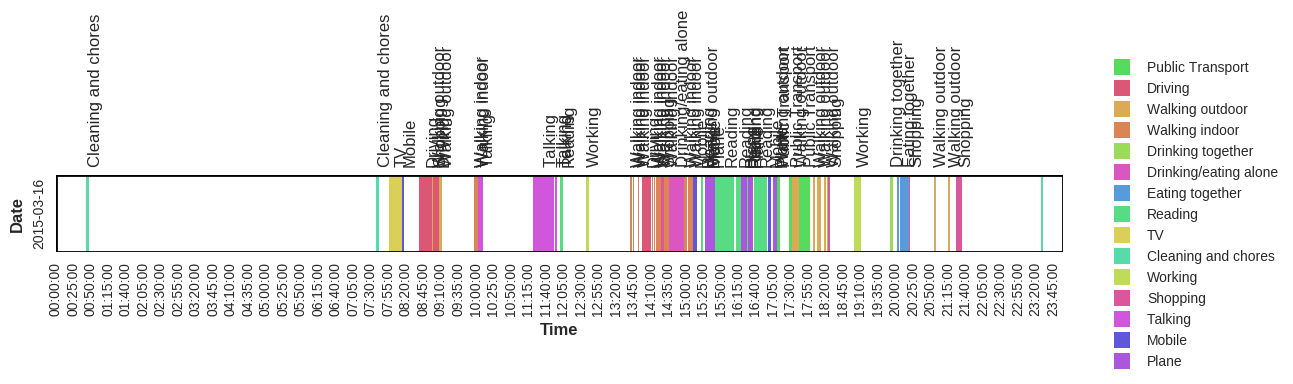

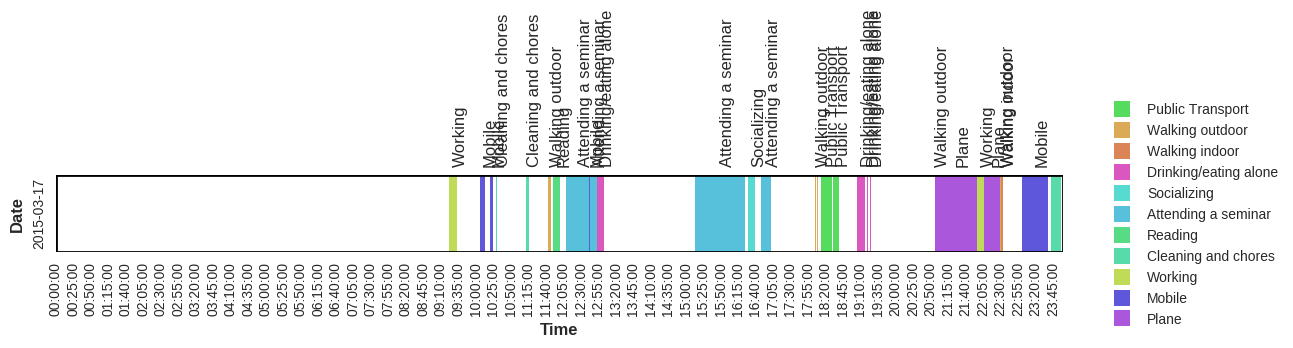

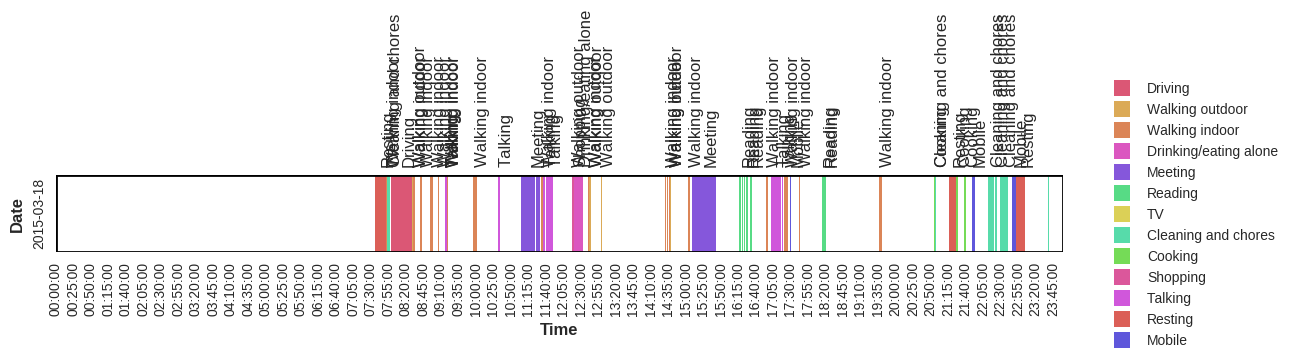

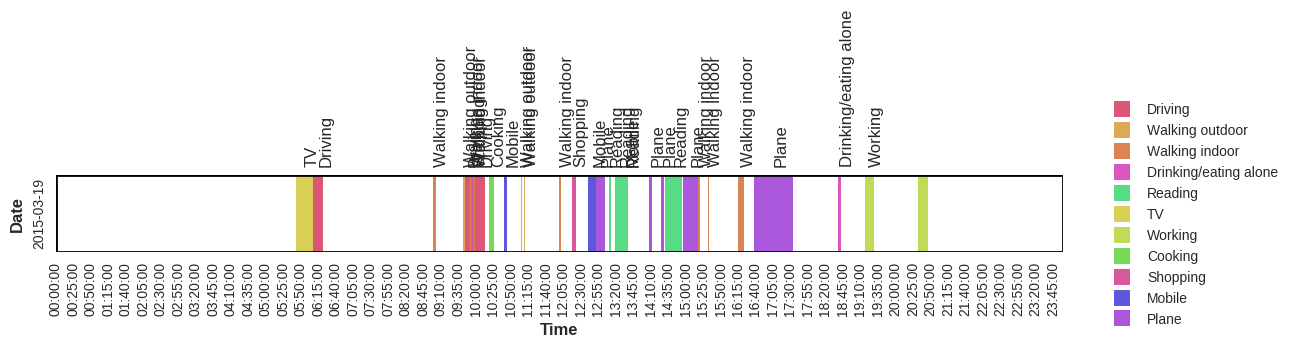

In [20]:
Sequence = collections.namedtuple('Sequence', 'start end')

Activity = collections.namedtuple('Activity', 'name sequence')


for user in users:    
    for i, d in enumerate(user.days):
        activities = list()
        day = -np.ones((1, 2880), np.int)
                
        start = -1
        current_label = -1
        last_index = -1
        for j, img in enumerate(d.images):
            index = time2ind(img.time)            
            day[0,index] = img.label
            
            if current_label != img.label or index-last_index > 5:
                if start > -1:                    
                    sequence = Sequence(start, last_index)
                    name = categories[current_label]
                    activities.append(Activity(name, sequence))
                start = index
                current_label = img.label            
            last_index = index

            

        start_ind = time2ind(d.images[0].time)
        end_ind = time2ind(d.images[-1].time)
        
#         dataframe = pd.DataFrame(data=day[:,start_ind:end_ind], index=[date.date],columns=times[start_ind:end_ind])
        dataframe = pd.DataFrame(data=day, index=[d.date],columns=times)
        fig, ax = bs.show_sequences(dataframe,labels_colors,figsize=(13,1),xticklabels=50,mask_value=-1,leg_square_size=6,show_box=True,plot_xlabel='Time',plot_ylabel='Date')
        props = {'ha': 'left', 'va': 'bottom'}
        
        for activity in activities:
            seq = activity.sequence

#             plt.text((seq.start+seq.end)/2-start_ind, 1.1, activity.name, props, rotation=90)
            plt.text((seq.start+seq.end)/2, 1.1, activity.name, props, rotation=90)
        plt.show()
        
    break

In [25]:
num_annotations_by_day = list()
num_days = 0
for user in users:    
    for i, day in enumerate(user.days):       
        if day.num_images > 1400:
            print "{} - {}".format(user.id_, day.date)
        num_annotations_by_day.append(day.num_images)
        num_days += 1
bs.print_attribute('Total number of days', num_days)

u3 - 2015-07-11


<brightside.Attribute instance at 0x7fbe17973560>

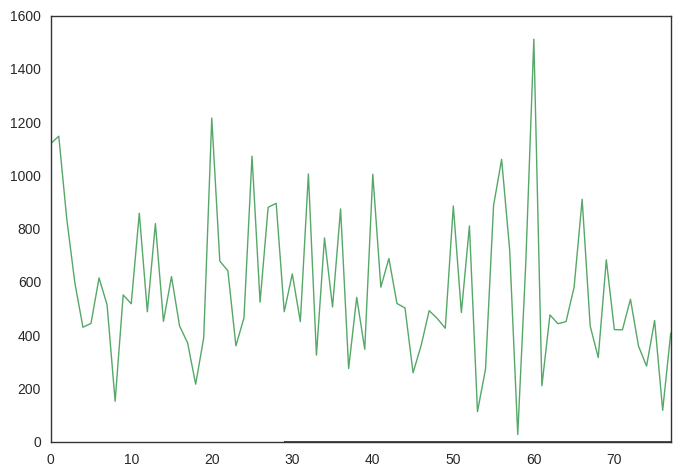

In [23]:
num_annotations_by_day= pd.Series(num_annotations_by_day)
num_annotations_by_day.hist()
num_annotations_by_day.plot()

In [ ]:
from collections import defaultdict

num_annotations = defaultdict(lambda: defaultdict(int))

for user in users:    
    for i, date in enumerate(user.dates):        
        num_annotations_by_day.append(len((date.images)))     